In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from IPython.display import display

/home/zhangjx/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


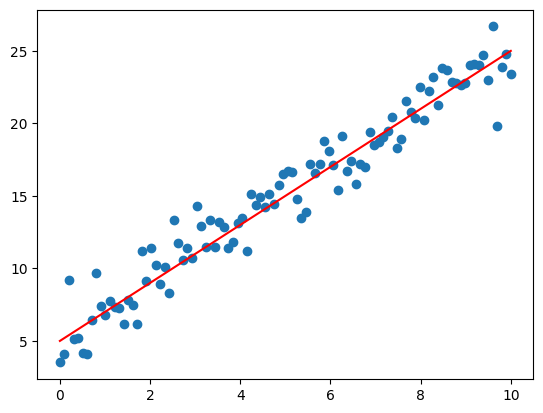

In [3]:
# creat data 以拟合线性函数为例子
#定义线性方程的斜率和截距
m = 2
b = 5
#生成x和y数据
x = np.linspace(0,10,100)
y = m*x+b

#加入高斯噪声
mu, sigama = 0,1.5  #噪声的均值和标准差
noise = np.random.normal(mu, sigama, len(y)) #生成随机噪声
noisy_y = y + noise #将噪声加到y数据中
plt.plot(x, y, color='red')
plt.scatter(x, noisy_y)
#组合x和y数据为一个二维数组
data = np.column_stack((x,noisy_y))
np.random.shuffle(data) #打乱数据
np.save('./data/linear_data.npy',data.astype(np.float32))

In [4]:
# dataset
class MyDataset(Dataset):
    def __init__(self, mode, data_path):
        super(MyDataset, self).__init__()
        assert mode in ['train', 'val', 'test']
        data = np.load(data_path)
        length = len(data)
        if mode == 'train':
            self.data = data[:int(0.6 * length)]
        elif mode == 'val':
            self.data = data[int(0.6 * length) : int(0.8*length)]
        else:
            self.data = data[int(0.8*length):]

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [5]:
# model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear_0 = nn.Linear(1,1,bias=True)

    def forward(self, x):
        y = self.linear_0(x.unsqueeze(-1))
        return y

In [6]:
# Loss
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def forward(self, x, y):
        distance = torch.abs(y - x)
        loss = torch.sum(distance)
        loss_mean = loss / x.shape[0]
        return loss_mean

In [32]:
# 超参数
batch_size = 60
num_workers = 8
lr = 0.05
epochs = 300

In [30]:
data_path = './data/linear_data.npy'
train_data = MyDataset('train', data_path)
val_data   = MyDataset('val', data_path)
test_data  = MyDataset('test', data_path)
train_dataloader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              num_workers=num_workers, 
                              drop_last=True, 
                              shuffle=True)
val_dataloader   = DataLoader(val_data, 
                              batch_size=1, 
                              num_workers=num_workers)
test_dataloader  = DataLoader(test_data, 
                              batch_size=1, 
                              num_workers=num_workers)
model = MyModel()
loss_f = Loss()
optimizer = SGD(model.parameters(),
            lr=lr)

torch.FloatTensor
torch.FloatTensor


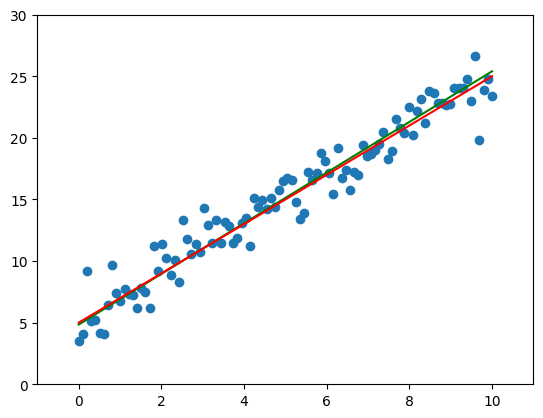

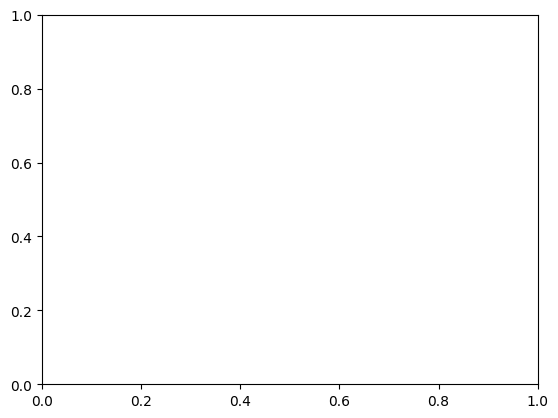

In [33]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlim(-1, 11)
ax.set_ylim(0, 25)
display(fig, display_id='plot')
for epoch in range(epochs):
    for data in train_dataloader:
        output = model(data[:,0])
        loss = loss_f(output.squeeze(-1), data[:,1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_sum = 0
    with torch.no_grad():
        for data in val_dataloader:
            output = model(data[:,0])
            loss = loss_f(output, data[:,1])
            loss_sum = loss_sum + loss
    m = model.linear_0.weight.data
    b = model.linear_0.bias.data
    y_show = m * x + b
    ax.set_xlim(-1, 11)
    ax.set_ylim(0, 30)
    ax.scatter(x, noisy_y)
    ax.plot(x, y_show[0], color='green')
    ax.plot(x, y, color='red')
    display(fig, display_id='plot',update=True)
    ax.clear()
loss_sum = 0
for data in  test_dataloader:
    output = model(data[:,0])
    loss = loss_f(output, data[:,1])
    loss_sum = loss_sum + loss